In [1]:
TUMOR = 'INTESTINAL'

# LIBS

In [2]:
# Standard library
import os
import glob
import warnings

# Data handling and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Model loading
import joblib

# Scikit-learn: model evaluation
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

# Suppress warnings
warnings.filterwarnings('ignore')


# FILES

In [3]:
df = pd.read_csv(f'../../datasets/{TUMOR}/dataset.csv') 
X = df.drop(['Survival Days', 'Death (180 Days)'],axis=1)
y = df['Death (180 Days)']

# Logistic Regression Model

In [4]:
# Direct path to the Logistic Regression model
model_path = os.path.join('models', TUMOR, 'LR.joblib')

# Load the model
lr_model = joblib.load(model_path)

# Display the loaded model
print(lr_model)

Pipeline(steps=[('normalization', MinMaxScaler()),
                ('imputation', KNNImputer(n_neighbors=3, weights='distance')),
                ('balancing',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy=0.2000000004128729)),
                ('model',
                 LogisticRegression(C=0.024024134747225607,
                                    class_weight='balanced',
                                    l1_ratio=0.4832773488031572, max_iter=3809,
                                    multi_class='auto', random_state=42,
                                    solver='saga'))])


# Generate predictions using 5-fold cross-validation

In [5]:
y_pred = cross_val_predict(lr_model, X, y.values.ravel(), cv=5)
y_proba = cross_val_predict(lr_model, X, y.values.ravel(), cv=5, method='predict_proba')[:, 1]

# Classification report


In [6]:
print("Classification Report:")
print(classification_report(y, y_pred))

Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.75      0.83       250
        True       0.35      0.72      0.47        47

    accuracy                           0.74       297
   macro avg       0.64      0.74      0.65       297
weighted avg       0.84      0.74      0.77       297



# Confusion matrix


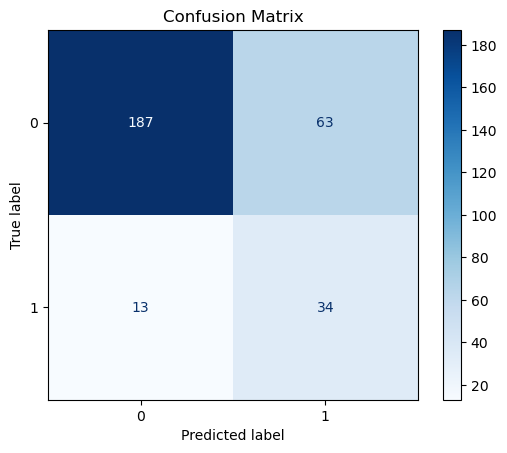

In [7]:
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# ROC curve

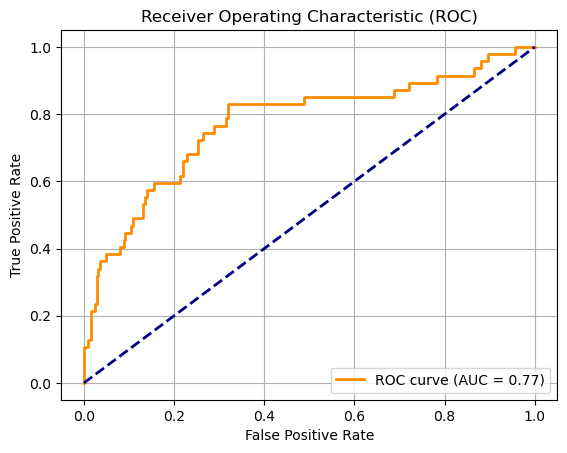

In [8]:
fpr, tpr, thresholds = roc_curve(y, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Feature Importance

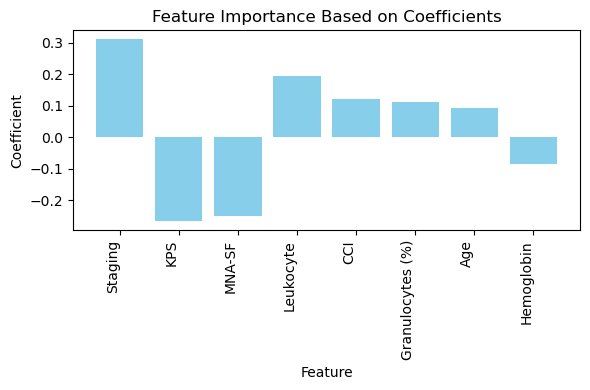

In [9]:
# Get the feature coefficients
coefficients = lr_model.named_steps['model'].coef_[0]

# Create a DataFrame to display the importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})

# Calculate the absolute coefficients for sorting by importance
importance_df['AbsoluteCoefficient'] = importance_df['Coefficient'].abs()

# Sort the DataFrame by the absolute values of the coefficients and reset the index
importance_df = importance_df.sort_values(by='AbsoluteCoefficient', ascending=False).reset_index(drop=True)

# Plot a bar chart to visualize feature importance based on coefficients
plt.figure(figsize=(6, 4))
plt.bar(importance_df['Feature'], importance_df['Coefficient'], color='skyblue')
plt.xticks(rotation=90, ha='right')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Feature Importance Based on Coefficients')
plt.tight_layout()
plt.show()